In [149]:
import os
os.environ["LANGSMITH_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "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"

import getpass

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-4o-mini", model_provider="openai")


if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")


from langchain_community.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

# Define the storage directory
persist_directory = "./chroma_db"

# Initialize Chroma with persistence
catalog_store = Chroma(
    collection_name="Catalog",
    embedding_function=embeddings,
    persist_directory=persist_directory  # Specify where to store the database
)
courses_store = Chroma(
    collection_name="Courses",
    embedding_function=embeddings,
    persist_directory=persist_directory  # Specify where to store the database
)

print(f"ChromaDB is stored at: {persist_directory}")


from langchain_core.prompts import ChatPromptTemplate
from langchain import hub
prompt = ChatPromptTemplate.from_template("You are an assistant meant to help Vanderbilt students with course registration and other relevant Vanderbilt information. Use the following pieces of retrieved context to answer the question. You will not go outside the scope of the retrieved context. If the answer to the question is not present in the retrieved context then reply \" That question is outside the scope of my knowledge: try rephrasing.\" Keep the answer as concise as possible while still answering the question completely.\n\nContext: {context} \n\nQuestion: {question} \n\nAnswer:")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()
assert len(example_messages) == 1
print(example_messages[0].content)


ChromaDB is stored at: ./chroma_db
You are an assistant meant to help Vanderbilt students with course registration and other relevant Vanderbilt information. Use the following pieces of retrieved context to answer the question. You will not go outside the scope of the retrieved context. If the answer to the question is not present in the retrieved context then reply " That question is outside the scope of my knowledge: try rephrasing." Keep the answer as concise as possible while still answering the question completely.

Context: (context goes here) 

Question: (question goes here) 

Answer:


ChromaDB is stored at: ./chroma_db


In [2]:
# from langchain_community.document_loaders import PyPDFLoader

# # Load the PDF file
# pdf_loader = PyPDFLoader("Undergraduate_Catalog_2024-25.pdf")
# documents = pdf_loader.load()

In [20]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# # Initialize the text splitter
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=1000,  # Number of characters per chunk
#     chunk_overlap=300,  # Overlap between chunks
# )

# # Split the documents
# split_documents = text_splitter.split_documents(documents)
# print(f"Split catalog into {len(split_documents)} sub-documents.")

Split catalog into 1953 sub-documents.


In [103]:
catalog = catalog_store.get()
courses = courses_store.get()
for i, metadata in enumerate(courses['metadatas']):
    print(f"\nDocument {i} metadata:")
    print(metadata)

# for i, metadata in enumerate(catalog['metadatas']):
#     print(f"\nDocument {i} metadata:")
#     print(metadata)


Document 0 metadata:
{'course_name': 'CORE1010 - Being Human', 'subject_area': 'A&S College Core'}

Document 1 metadata:
{'course_name': 'CORE1020 - Science, Technology, Values', 'subject_area': 'A&S College Core'}

Document 2 metadata:
{'course_name': 'CORE2500 - Exploratory Core - Special Topic', 'subject_area': 'A&S College Core'}

Document 3 metadata:
{'course_name': 'AADS1001 - Commons iSeminar', 'subject_area': 'African American Diaspora Studies'}

Document 4 metadata:
{'course_name': 'AADS1010 - Introduction to African American and Diaspora Studies', 'subject_area': 'African American Diaspora Studies'}

Document 5 metadata:
{'course_name': 'AADS1016 - Race Matters', 'subject_area': 'African American Diaspora Studies'}

Document 6 metadata:
{'course_name': 'AADS1108 - Making of the African Diaspora', 'subject_area': 'African American Diaspora Studies'}

Document 7 metadata:
{'course_name': 'AADS1111 - First-Year Writing Seminar', 'subject_area': 'African American Diaspora Studie

In [3]:
import json
from langchain.schema import Document

# Load chunks from JSON file
with open("chunks.json", "r", encoding="utf-8") as file:
    chunk_data = json.load(file)  # Parse JSON file

# Convert JSON data into LangChain Document objects
catalog_documents = [
    Document(
        page_content=chunk["text"],  # Extract text content
        metadata={"id": chunk["id"], "page": chunk["metadata"]["page"], "source": "chunks.json"}
    )
    for chunk in chunk_data
]

print(f"Loaded {len(catalog_documents)} chunks from chunks.json.")

catalog_document_ids = catalog_store.add_documents(documents=catalog_documents)

print(catalog_document_ids[:3])

Loaded 1217 chunks from chunks.json.
['18563ecb-baf9-483e-8d8f-091d2b16cadc', 'd9c59b1f-f884-4364-ba9c-c1ba23c9049e', '34c4d587-ca22-4222-8690-fbee62ede94d']


In [111]:
import csv
from langchain_core.documents import Document

# DONT NEED TO RERUN
def read_csv_to_list(file_path):
    documents = []
    metadata = []
    ids = []
    
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for i, row in enumerate(reader):
            if i >= 1:
                page_content = ', '.join(row)  # Convert row to a string
                
                if len(row) > 1:
                    course_code = row[1].split(' -')[0]  # Strip everything including and after '-'
                    doc_metadata = {'course_code': course_code, 'subject_area': row[0]}  # Extract cleaned course 
                    metadata.append(doc_metadata)
                
                ids.append(f"doc_{i}")  # Assign a unique ID to each document
                
                # Create a Document object with page_content and metadata
                documents.append(Document(page_content=page_content, metadata=doc_metadata))

    return documents, metadata, ids

# Example usage
file_path = 'subject_courses.csv'  # Replace with your actual file path
course_documents, course_metadata, ids = read_csv_to_list(file_path)


In [112]:
courses_store.add_documents(documents=course_documents, metadata=course_metadata)

['6e658acb-4494-4bf1-9fbf-203942a1f68b',
 '2dda5e5f-d072-4bd3-ac4a-b7ff97a58a4f',
 '1d71493a-2593-4008-abeb-841b55f9a4c3',
 'dfbfd614-eb04-4ace-b70c-9d737a43478f',
 '54983b8d-b116-4112-8af8-1f3acb6eb189',
 '358d9e8f-00e8-4c41-83f3-5258a2a1ccce',
 'd70d3f92-1407-4559-8a01-164d6725a571',
 '0938637e-cab7-4f51-b15f-b07c01d53a00',
 '52985674-f9b8-471a-b7b1-556ef545f0fd',
 '031440ea-0593-4cf8-8ecb-e49429e4728a',
 '211ca73d-b264-4013-b419-990351524404',
 'fee393c8-0349-4e38-8cd4-f95df1a129d1',
 'bee983e0-9392-4268-87f5-6d663a3d4fe6',
 'b19d7ce0-dd3a-41fd-8cee-27687b987706',
 '9109c519-ace4-42a5-ba4d-510940d71448',
 '0d17f0b5-c1f9-46d1-84b9-9a503aec0eea',
 '1c532da2-8f40-4201-b771-cc7064bffd8e',
 'a4334cbf-710a-4788-b4fb-966414ce1560',
 'd5e92f7b-11cb-4338-b327-d67d22c704de',
 '0328eb01-dcd4-46e0-b025-a0313f00ea44',
 'a8923f54-9bd0-4784-af7b-0b8bc39b6900',
 '3e6730c2-bfed-4f0c-9ec9-95aa2397169f',
 '02faf4a5-688e-41b9-991f-2123347ca9de',
 'ff890c52-78c0-48e4-9493-66ef0f3b0b7d',
 'c65a2f0d-48ad-

We'll use LangGraph to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
We get streamlined deployments via LangGraph Platform.
LangSmith will automatically trace the steps of our application together.
We can easily add key features to our application, including persistence and human-in-the-loop approval, with minimal code changes.

[Document(metadata={'subject_area': 'A&S College Core', 'course_name': 'CORE1010 - Being Human'}, page_content='CORE1010 - Being Human: This course invites you to launch your undergraduate career with some of the biggest questions humans have asked: Who are we, and why are we here? To begin, we will ask: why are we here at Vanderbilt, and what is the purpose of a college education? We will then examine the varied ways that people in different times, places, and circumstances have contemplated the meaning of humanity-raising questions about social ﬂourishing and responsibility; about solidarity, hierarchy, and difference; and about the very boundaries of "the human." Incoming Arts and Science first-year students will continue with CORE 1020 in the spring.  Limited to incoming first-year students only.  Offered on a graded basis only. [3] (HCA)'),
 Document(metadata={'subject_area': 'A&S College Core', 'course_name': 'CORE1020 - Science, Technology, Values'}, page_content='CORE1020 - Sci

In [150]:
from typing import TypedDict
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""
    query: Annotated[str, ..., "Search query to run."]

In [151]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [152]:
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

In [163]:
def retrieve(state: State):
    query = state["query"]
    # Retrieve 4 documents from each collection
    catalog_docs = catalog_store.similarity_search(query["query"], k=1)
    courses_docs = courses_store.similarity_search(query["query"], k=1)

    # Label and retain metadata
    labeled_catalog_docs = [
    {
        "content": doc.page_content,
        "source": doc.metadata.get("source", "Undergraduate Catalog Information"),
        "metadata": doc.metadata  # Retain metadata
    }
    for doc in catalog_docs
    ]

    labeled_courses_docs = [
    {
        "content": doc.page_content,
        "source": doc.metadata.get("source", "Course Information"),
        "metadata": doc.metadata  # Retain metadata
    }
    for doc in courses_docs
    ]   
    print(labeled_catalog_docs)
    print(labeled_courses_docs)
    # Combine results
    retrieved_docs = labeled_catalog_docs + labeled_courses_docs

    return {"context": retrieved_docs}


retrieve stores retrieved docs from the vector store^

Successfully updated metadata for 1217 documents.


In [154]:
def generate(state: State):
    # Format retrieved documents with labels
    docs_content = "\n\n".join(
        f"[{doc['source']}] {doc['content']}" for doc in state["context"]
    )

    # Generate the full prompt
    full_prompt = prompt.invoke({"question": state["question"], "context": docs_content})

    # Get response from LLM
    response = llm.invoke(full_prompt)
    # print(full_prompt)
    # Return both the answer and the full prompt
    return {"answer": response.content, "prompt": full_prompt}


calls the prompt and passes in the context and question to messages, and sends messages to the llm

In [164]:
from langgraph.graph import START, StateGraph, MessagesState

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

state object keeping track of everything. retrieve and generate are executed in order and modify the state object. retrieve is connected to the starting point

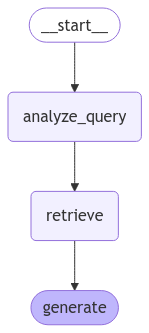

In [158]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [165]:
result = graph.invoke({"question": "what are the requirements for the computer science major and what liberal arts classes can i take in my freshmen year for it"})
print('\n\n\n\n')
# print(json.dumps(result['answer'], indent=2))
print(f'Query for retrieval: {result['query']}\n\n')
print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

[{'content': '10. Open Electives (18–20 hours).\n11. Computers and Ethics (3 hours) CS 1151. May be used to satisfy three hours from the Liberal Arts Core (#4)\nor Open Electives (#10). May not be taken on a pass/fail grading basis by CS majors or minors.\n12. Writing Component (3 hours). At least one “W”-designated course or 1111 course in the English Language\nmust be included from the Liberal Arts Core (#4), Technical Electives (#9), or Open Electives (#10).\nUndergraduates in computer science may apply the pass/fail option only to courses taken as open electives,\ntechnical electives, or part of the liberal arts core, subject to the school requirements for pass/fail.\nSpecimen Curriculum for Computer Science\nPage 204 of 1019', 'source': 'Undergraduate_Catalog', 'metadata': {'id': '10e18551-0f43-4d2a-a01b-0e7e6d763136', 'page': 204, 'source': 'Undergraduate_Catalog'}}]
[{'content': 'Computer Science, CS1000 - The Beauty and Joy of Computing, Fundamental concepts of computing includ

In [135]:
result

{'question': 'who won the world series',
 'query': {'query': '2023 World Series winner'},
 'context': [{'content': 'Adolpho A. Birch III, Secretary (Nashville, TN)\nVoting Members\nLamar Alexander (Walland, TN)\nGreg S. Allen (Charlottesville, VA)\nJohn Arnold (Houston, TX)\nSean Connolly (Winnetka, IL)\nLawrence Epstein (Las Vegas, NV)\nAdena T. Friedman (Chevy Chase, MD)\nJennifer Frist (Nashville, TN)\nAndrew Hoine (New York, NY)\nGeorge Huber (Bellevue, WA)\nKito K. Huggins (Brooklyn, NY)\nDavid B. Ingram (Nashville, TN)\nJustin Ishbia (Chicago, IL)\nPage 484 of 1019',
   'source': 'Undergraduate Catalog Information',
   'metadata': {'id': 'e31560cf-e397-4fae-b991-6015899a7c59',
    'page': 484,
    'source': 'Undergraduate_Catalog'}},
  {'content': 'Undergraduate Catalog\nVanderbilt University\n2024/2025\nContaining general information and courses of study for the 2024/2025 session',
   'source': 'Undergraduate Catalog Information',
   'metadata': {'id': '9fae3bf7-0b8c-4ff8-8947-5

In [ ]:
for message, metadata in graph.stream(
    {"question": "What is the computer science major?"}, stream_mode="messages"
):
    print(message.content, end="|")



#this code streams output in a token by token stream